In [11]:
import pandas as pd
import matplotlib.pyplot as plt
# import mediapipe as mp
import cv2

In [ ]:
# Carregar o dataset
df = pd.read_csv('fairface_label_val.csv')

# Inicializar BlazeFace
mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.5)

def load_image(img_path):
    img = plt.imread(img_path)
    if img.shape[-1] == 4:
        img = img[..., :3]  # Descartar o canal alfa, se presente
    return img

def detect_faces(image):
    results = face_detection.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.detections:
        return True
    return False

# Aplicar detecção de rosto em todas as imagens do dataset
df['face_detected'] = df['file'].apply(lambda x: detect_faces(load_image(x)))

In [5]:
# df['gabarito'] = True
df = pd.read_csv('blazeface.csv')
df

,Unnamed: 0,file,age,gender,race,service_test,face_detected,gabarito
0,0,val/1.jpg,3-9,Male,East Asian,False,True,True
1,1,val/2.jpg,50-59,Female,East Asian,True,True,True
2,2,val/3.jpg,30-39,Male,White,True,True,True
3,3,val/4.jpg,20-29,Female,Latino_Hispanic,True,True,True
4,4,val/5.jpg,20-29,Male,Southeast Asian,False,True,True
...,...,...,...,...,...,...,...,...
10949,10949,val/10950.jpg,30-39,Male,White,True,True,True
10950,10950,val/10951.jpg,50-59,Male,White,False,True,True
10951,10951,val/10952.jpg,60-69,Male,Latino_Hispanic,False,True,True
10952,10952,val/10953.jpg,20-29,Female,East Asian,False,True,True


In [6]:
from collections import Counter
Counter(df['face_detected'])

Counter({True: 9651, False: 1303})

In [7]:
df[df['face_detected']==False]['race'].value_counts()

race
White              289
Black              230
Latino_Hispanic    204
Indian             177
East Asian         144
Middle Eastern     141
Southeast Asian    118
Name: count, dtype: int64

In [29]:
from fairlearn.metrics import MetricFrame, true_positive_rate, true_negative_rate, false_positive_rate, false_negative_rate, selection_rate


# Verificar se a coluna 'service_test' representa a verdade sobre a presença de um rosto
df['face_present'] = df['service_test']  # Supondo que 'service_test' é True se um rosto está presente
# Definir as colunas para avaliação
y_true = df['face_present']
y_pred = df['face_detected']
sensitive_features = df[['race']]


# Calcular métricas usando Fairlearn
metrics = {
    'true_positive_rate': true_positive_rate,
    'false_positive_rate': false_positive_rate,
    'true_negative_rate': true_negative_rate,
    'false_negative_rate': false_negative_rate,
    'selection_rate': selection_rate
}

metric_frame = MetricFrame(metrics=metrics, y_true=y_true, y_pred=y_pred, sensitive_features=sensitive_features)

# Paridade Demográfica: selection_rate
demographic_parity = metric_frame.by_group['selection_rate']
print("\nParidade Demográfica (Taxa de Seleção por Raça):")
print(demographic_parity)

# Igualdade de Oportunidade: true_positive_rate
equalized_opportunity = metric_frame.by_group['true_positive_rate']
print("\nIgualdade de Oportunidade (Taxa de Verdadeiros Positivos por Raça):")
print(equalized_opportunity)

# Igualdade de Chance: true_positive_rate e false_positive_rate
true_positive_rates = metric_frame.by_group['true_positive_rate']
false_positive_rates = metric_frame.by_group['false_positive_rate']

# Agrupar por raça e calcular as diferenças máximas e mínimas
max_diff_tpr = true_positive_rates.groupby(level='race').transform(lambda x: (x.max() - x.min()).round(6),)
max_diff_fpr = false_positive_rates.groupby(level='race').transform(lambda x: (x.max() - x.min()).round(6))

equalized_chance = pd.DataFrame({
    'true_positive_rate': true_positive_rates,
    'false_positive_rate': false_positive_rates,
    'max_diff_tpr': max_diff_tpr,
    'max_diff_fpr': max_diff_fpr
})

equalized_chance['equalized_chance'] = equalized_chance['max_diff_tpr'] + equalized_chance['max_diff_fpr']

print("\nIgualdade de Chance (Taxas de Verdadeiros Positivos e Falsos Positivos por Raça):")
print(equalized_chance['equalized_chance'])

# Compare true positive rate and false positive rate for each group
predictive_parity = (true_positive_rates - false_positive_rates).abs()

print("Predictive Parity (Absolute Difference between True Positive Rate and False Positive Rate by Race):")
print(predictive_parity)

# Compute false positive rate and false negative rate by group
false_positive_rates = metric_frame.by_group['false_positive_rate']
false_negative_rates = metric_frame.by_group['false_negative_rate']

# Compare false positive rate and false negative rate for each group
treatment_equality = (false_positive_rates - false_negative_rates).abs()

print("Equality of Treatment (Absolute Difference between False Positive Rate and False Negative Rate by Race):")
print(treatment_equality)


Paridade Demográfica (Taxa de Seleção por Raça):
race
Black              0.852185
East Asian         0.907097
Indian             0.883245
Latino_Hispanic    0.874307
Middle Eastern     0.883375
Southeast Asian    0.916608
White              0.861391
Name: selection_rate, dtype: float64

Igualdade de Oportunidade (Taxa de Verdadeiros Positivos por Raça):
race
Black              0.855191
East Asian         0.902643
Indian             0.889041
Latino_Hispanic    0.877883
Middle Eastern     0.889885
Southeast Asian    0.914952
White              0.858311
Name: true_positive_rate, dtype: float64

Igualdade de Chance (Taxas de Verdadeiros Positivos e Falsos Positivos por Raça):
race
Black              0.0
East Asian         0.0
Indian             0.0
Latino_Hispanic    0.0
Middle Eastern     0.0
Southeast Asian    0.0
White              0.0
Name: equalized_chance, dtype: float64
Predictive Parity (Absolute Difference between True Positive Rate and False Positive Rate by Race):
race
Black   


Taxas de Erro por Raça:
True Race-Gender
Black              0.517995
East Asian         0.533548
Indian             0.508575
Latino_Hispanic    0.531115
Middle Eastern     0.379653
Southeast Asian    0.489046
White              0.609113
Name: Error, dtype: float64


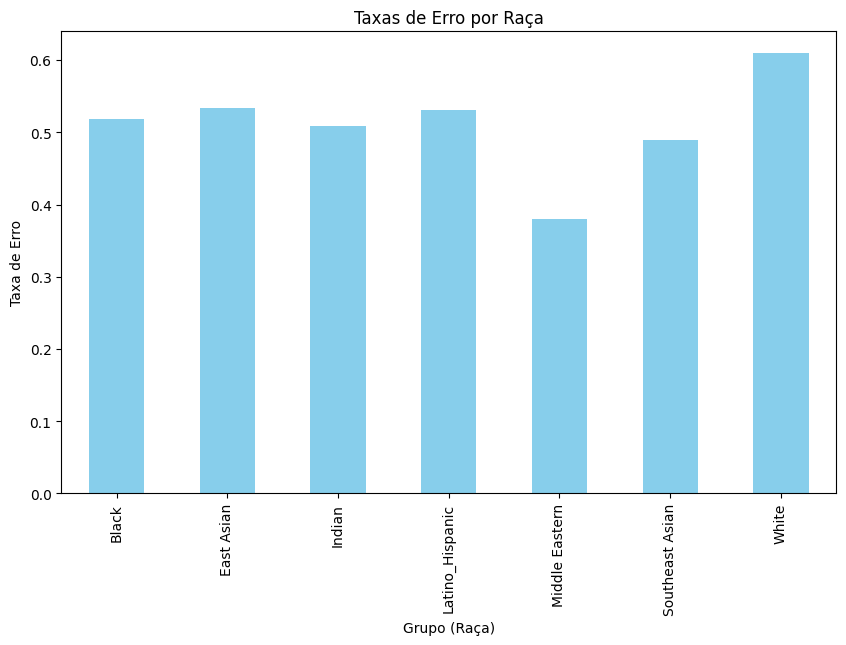

In [39]:
# Analisar a distribuição de erros por raça e gênero
# Verificar se a coluna 'service_test' representa a verdade sobre a presença de um rosto
df['face_present'] = df['service_test']  # Supondo que 'service_test' é True se um rosto está presente
# Definir as colunas para avaliação
y_true = df['face_present']
y_pred = df['face_detected']
sensitive_features = df[['race']]

results_df = pd.DataFrame({'Face Exists': y_true, 'Pred Face': y_pred, 'Race Name': df['race']})
results_df['Error'] = results_df['Face Exists'] != results_df['Pred Face']

# Criar colunas combinadas para raça e gênero
results_df['True Race-Gender'] = results_df['Race Name']
results_df['Pred Race-Gender'] = results_df['Race Name']

# Calcular as taxas de erro por grupo
group_error_rates = results_df.groupby('True Race-Gender')['Error'].mean()

# Exibir taxas de erro por grupo
print("\nTaxas de Erro por Raça:")
print(group_error_rates)

# Plotar taxas de erro por grupo
plt.figure(figsize=(10, 6))
group_error_rates.plot(kind='bar', color='skyblue')
plt.xlabel('Grupo (Raça)')
plt.ylabel('Taxa de Erro')
plt.title('Taxas de Erro por Raça')
plt.show()

In [40]:
results_df[results_df['Race Name']=='White']

,Face Exists,Pred Face,Race Name,Error,True Race-Gender,Pred Race-Gender
2,True,True,White,False,White,White
17,False,True,White,True,White,White
18,False,True,White,True,White,White
21,False,True,White,True,White,White
22,True,False,White,True,White,White
...,...,...,...,...,...,...
10943,False,True,White,True,White,White
10945,False,True,White,True,White,White
10947,True,True,White,False,White,White
10949,True,True,White,False,White,White


In [33]:
group_error_rates

Series([], Name: Error, dtype: float64)

In [20]:
# Mostrar resultados
print("Paridade Demográfica:\n", paridade_demografica.nlargest(3))

Paridade Demográfica:
 gender  race           
Female  Southeast Asian    0.930882
        East Asian         0.924968
        Indian             0.904325
Name: selection_rate, dtype: float64


In [16]:
print("Igualdade de Oportunidade:\n", igualdade_oportunidade)

Igualdade de Oportunidade:
 gender  race           
Female  Black              0.890449
        East Asian         0.923729
        Indian             0.899471
        Latino_Hispanic    0.908616
        Middle Eastern     0.893939
        Southeast Asian    0.927419
        White              0.879656
Male    Black              0.821809
        East Asian         0.882192
        Indian             0.877841
        Latino_Hispanic    0.844633
        Middle Eastern     0.885714
        Southeast Asian    0.901961
        White              0.838961
Name: true_positive_rate, dtype: float64


In [17]:
print("Igualdade de Chance:\n", igualdade_chance)

Igualdade de Chance:
 {'true_positive_rate': gender  race           
Female  Black              0.890449
        East Asian         0.923729
        Indian             0.899471
        Latino_Hispanic    0.908616
        Middle Eastern     0.893939
        Southeast Asian    0.927419
        White              0.879656
Male    Black              0.821809
        East Asian         0.882192
        Indian             0.877841
        Latino_Hispanic    0.844633
        Middle Eastern     0.885714
        Southeast Asian    0.901961
        White              0.838961
Name: true_positive_rate, dtype: float64, 'false_negative_rate': gender  race           
Female  Black              0.109551
        East Asian         0.076271
        Indian             0.100529
        Latino_Hispanic    0.091384
        Middle Eastern     0.106061
        Southeast Asian    0.072581
        White              0.120344
Male    Black              0.178191
        East Asian         0.117808
        Indian

In [18]:
print("Paridade Preditiva:\n", paridade_preditiva)

Paridade Preditiva:
 {'true_positive_rate': gender  race           
Female  Black              0.890449
        East Asian         0.923729
        Indian             0.899471
        Latino_Hispanic    0.908616
        Middle Eastern     0.893939
        Southeast Asian    0.927419
        White              0.879656
Male    Black              0.821809
        East Asian         0.882192
        Indian             0.877841
        Latino_Hispanic    0.844633
        Middle Eastern     0.885714
        Southeast Asian    0.901961
        White              0.838961
Name: true_positive_rate, dtype: float64, 'false_positive_rate': gender  race           
Female  Black              0.865337
        East Asian         0.926014
        Indian             0.909091
        Latino_Hispanic    0.888143
        Middle Eastern     0.000000
        Southeast Asian    0.935065
        White              0.894137
Male    Black              0.834515
        East Asian         0.895631
        Indian 

In [19]:
print("Igualdade de Tratamento:\n", igualdade_tratamento)

Igualdade de Tratamento:
 {'true_positive_rate': gender  race           
Female  Black              0.890449
        East Asian         0.923729
        Indian             0.899471
        Latino_Hispanic    0.908616
        Middle Eastern     0.893939
        Southeast Asian    0.927419
        White              0.879656
Male    Black              0.821809
        East Asian         0.882192
        Indian             0.877841
        Latino_Hispanic    0.844633
        Middle Eastern     0.885714
        Southeast Asian    0.901961
        White              0.838961
Name: true_positive_rate, dtype: float64, 'true_negative_rate': gender  race           
Female  Black              0.134663
        East Asian         0.073986
        Indian             0.090909
        Latino_Hispanic    0.111857
        Middle Eastern     0.000000
        Southeast Asian    0.064935
        White              0.105863
Male    Black              0.165485
        East Asian         0.104369
        Ind